# Predict age from AFQ-Browser-Demo data using AFQ-Insight

In [1]:
import afqinsight as afqi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import ipywidgets

from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, export_png
from bokeh.embed import file_html
from bokeh.layouts import row, column, widgetbox
from bokeh.models import BoxSelectTool, ColorBar, CustomJS, HoverTool, Legend, Range1d, Title, Whisker
from bokeh.models.tickers import FixedTicker
from bokeh.models.annotations import LegendItem
from bokeh.palettes import Spectral10, Cividis256, Category10_10
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.resources import CDN
from bokeh.models.mappers import LinearColorMapper

from sklearn.decomposition import PCA

%matplotlib notebook

In [2]:
output_notebook()

Loading BokehJS ...

## Load the data

In [3]:
afq_data = afqi.load_afq_data(
    '../data/raw/age_data',
    target_cols=['Age'],
    scale_x=False
)

x, y, groups, columns, bias_index = (
    afq_data.x,
    afq_data.y['Age'],
    afq_data.groups,
    afq_data.columns,
    afq_data.bias_index
)

In [4]:
print(len(y))
print(np.min(y))
print(np.max(y))

77
6
50


## Find the optimal feature coefficients $\widehat{\beta}$

We search for the optimal coefficients using two different loss types: square loss and huber.

In [5]:
# hp_cv_res_r2 = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=5, n_repeats=3,
#     max_evals_per_cv=50, loss_type='square',
#     beta0=None,
#     score='r2',
#     trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_r2',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]
0it [00:00, ?it/s, best loss: ?]



In [6]:
hp_cv_res_medae = afqi.fit_hyperparams_cv(
    x, y, groups, bias_index=bias_index,
    n_splits=5, n_repeats=3,
    max_evals_per_cv=51,
    loss_type='square',
    beta0=None,
    score='medae',
    trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_medae',
    verbose=1, random_state=42, clf_threshold=0.5
)

In [7]:
label_sets = afqi.multicol2sets(columns, tract_symmetry=True)
select_labels = [["fa"], ["md"]]
x_md_fa = afqi.select_groups(np.delete(x, bias_index, axis=1), select_labels, label_sets)
x_md_fa = np.hstack([x_md_fa, x[:, bias_index][:, np.newaxis]])

In [8]:
hp_cv_res_medae_md_fa = afqi.fit_hyperparams_cv(
    x_md_fa, y, groups[0:40], bias_index=4000,
    n_splits=5, n_repeats=3,
    max_evals_per_cv=41,
    loss_type='square',
    beta0=None,
    score='medae',
    trials_pickle_dir='./trials_age_from_demo_regression/cv3x5_rs42_transform_types_square_medae_md_fa_only',
    verbose=1, random_state=42, clf_threshold=0.5
)

In [9]:
[(cv["eta"], cv["transform_type"]) for cv in hp_cv_res_medae]

[(1.0600511810646331, 'exponentiation'),
 (1.0020598433267898, 'exponentiation'),
 (1.0068702080572887, 'exponentiation'),
 (1.02638042631787, 'exponentiation'),
 (1.025396676842336, 'exponentiation'),
 (1.0204869949808208, 'exponentiation'),
 (1.0061707663288886, 'exponentiation'),
 (1.0033298437899174, 'exponentiation'),
 (1.0025555027408934, 'exponentiation'),
 (1.0047972784439696, 'exponentiation'),
 (1.0172186252893334, 'exponentiation'),
 (1.0796138633443433, 'exponentiation'),
 (1.0831778092905289, 'exponentiation'),
 (1.014264329050301, 'exponentiation'),
 (1.032262579033703, 'exponentiation')]

In [10]:
def print_results_summary(hp_cv_results):
    template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
    test = [r["test"] for r in hp_cv_results]
    train = [r["train"] for r in hp_cv_results]
    test_rmse = [t["rmse"] for t in test]
    test_r2 = [t["r2"] for t in test]
    test_medae = [t["medae"] for t in test]
    train_medae = [t["medae"] for t in train]
    train_rmse = [t["rmse"] for t in train]
    train_r2 = [t["r2"] for t in train]

    print('Statistic         mean   (variance)')
    print('--------------  ------- ------------')
    print(template.format(stat='test RMSE', mean=np.mean(test_rmse), var=np.var(test_rmse)))
    print(template.format(stat='test med AE', mean=np.mean(test_medae), var=np.var(test_medae)))
    print(template.format(stat='test R2', mean=np.mean(test_r2), var=np.var(test_r2)))
    print(template.format(stat='train RMSE', mean=np.mean(train_rmse), var=np.var(train_rmse)))
    print(template.format(stat='train med AE', mean=np.mean(train_medae), var=np.var(train_medae)))
    print(template.format(stat='train R2', mean=np.mean(train_r2), var=np.var(train_r2)))

In [11]:
# print_results_summary(hp_cv_res_square)

In [12]:
# print_results_summary(hp_cv_res_r2)

In [13]:
print_results_summary(hp_cv_res_medae)

Statistic         mean   (variance)
--------------  ------- ------------
test RMSE        11.383 ( 11.147)
test med AE      5.4881 ( 8.8765)
test R2         -0.024376 (0.10235)
train RMSE       7.5987 (0.34357)
train med AE     4.2666 (0.31736)
train R2        0.60089 (0.0023209)


In [14]:
print_results_summary(hp_cv_res_medae_md_fa)

Statistic         mean   (variance)
--------------  ------- ------------
test RMSE        8.2328 ( 5.2538)
test med AE      3.1393 ( 1.1543)
test R2         0.47332 (0.064458)
train RMSE      0.98918 ( 1.4296)
train med AE     0.4747 (0.19351)
train R2        0.98223 (0.0025841)


In [20]:
cv_results = [cv for cv in hp_cv_res_medae]

test_set_y_hat = pd.concat([
    pd.Series(data=afqi.target_transformation(cv["test"]["x"].dot(cv["beta_hat"]),
                                              eta=cv["eta"],
                                              transform_type=cv["transform_type"]),
              index=cv["test"]["y"].index,
              name='yhat')
    for cv in cv_results
]).groupby('subjectID').mean()

test_set_cv_idx = pd.concat([
    pd.Series(data=np.ones_like(cv["test"]["y"].index) * idx,
              index=cv["test"]["y"].index,
              name='cv_idx')
    for idx, cv in enumerate(cv_results)
]).apply(pd.to_numeric).groupby('subjectID').mean()

# test_set_cv_color = pd.concat([
#     pd.Series(data=np.ones_like(cv.test.y.index) * Spectral10[idx % 10],
#               index=cv.test.y.index,
#               name='cv_color')
#     for idx, cv in enumerate(cv_results)
# ])

test_set_rmse = pd.concat([
    pd.Series(data=np.ones_like(cv["test"]["y"].index) * cv["test"]["rmse"],
              index=cv["test"]["y"].index,
              name='rmse')
    for cv in cv_results
]).apply(pd.to_numeric).groupby('subjectID').mean()

In [21]:
df_y = pd.concat([
    y,
    test_set_y_hat,
    test_set_cv_idx,
#     test_set_cv_color,
    test_set_rmse
], axis='columns', sort=True)
df_y['index'] = np.arange(len(y), dtype=np.int32)
df_y['stdres'] = (df_y['Age'] - df_y['yhat']) / (np.std(df_y['Age'] - df_y['yhat']))
df_y['res'] = df_y['Age'] - df_y['yhat']
df_y['size'] = 10 * df_y['rmse']
df_y['subject_id'] = df_y.index
df_y.head()

,Age,yhat,cv_idx,rmse,index,stdres,res,size,subject_id
subjectID,,,,,,,,,
subject_000,20,6.676814,6.666667,11.352732,0,1.364912,13.323186,113.527324,subject_000
subject_001,31,8.496414,6.333333,11.581434,1,2.305411,22.503586,115.814344,subject_001
subject_002,18,5.437816,8.000000,7.381990,2,1.286950,12.562184,73.819896,subject_002
subject_003,28,27.936779,6.666667,11.572333,3,0.006477,0.063221,115.723329,subject_003
subject_004,29,6.632908,6.666667,12.820446,4,2.291427,22.367092,128.204458,subject_004


In [22]:
p = figure(plot_width=600, plot_height=600, toolbar_location='above')
p.title.text = 'Residuals by subject'

source = ColumnDataSource(data=df_y)

hover = HoverTool(
    tooltips=[("Subject", "@subject_id"),
              ("Age", "@Age"),
              ("CV", "@cv_idx")],
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.circle(source=source,
         x='index',
         y='res',
#          color='cv_color',
         size='rmse',
         line_color=None)

p.xaxis.axis_label = 'Subject'
p.yaxis.axis_label = 'Residuals'

p.add_tools(hover)

# html = file_html(p, CDN, 'my plot')
# with open(op.abspath('../docs/img/bokeh_plots/regression_residuals_by_subject.html'), 'w') as fp:
#     fp.write(html)
show(p)

In [23]:
np.sqrt(np.square(df_y['res']).mean())

15.159374494904029

In [24]:
p = figure(plot_width=800, plot_height=800, toolbar_location=None, x_range=(0, 52), y_range=(0, 52))
p_res = figure(plot_width=800, plot_height=800, toolbar_location=None)
p.title.text = 'Predicted ages (test splits)'
p_res.title.text = 'Standardized residuals (test splits)'

source = ColumnDataSource(data=df_y)

hover = HoverTool(
    tooltips=[("Subject", "@subject_id"),
              ("Age", "@Age"),
              ("Residual", "@stdres"),
              ("CV", "@cv_idx")],
)
hover.point_policy = 'snap_to_data'
hover.line_policy = 'nearest'

p.scatter(source=source,
          x='yhat',
          y='Age',
#           color='cv_color',
          size=15,
          line_color='black')

p.line(x=[0, 52], y=[0, 52], line_color="black", line_width=2, line_dash='dashed')

p_res.scatter(source=source,
              x='yhat',
              y='stdres',
#               color='cv_color',
              size=15,
              line_color="black")

p.xaxis.axis_label = 'Predicted Age'
p.yaxis.axis_label = 'Actual Age'
p.xaxis.axis_label_text_font_size = "26pt"
p.yaxis.axis_label_text_font_size = "26pt"
p.xaxis.major_label_text_font_size = "20pt"
p.yaxis.major_label_text_font_size = "20pt"
p.title.text_font_size = "26pt"

p_res.xaxis.axis_label = 'Predicted Age'
p_res.yaxis.axis_label = 'Standardized Residuals'
p_res.xaxis.axis_label_text_font_size = "26pt"
p_res.yaxis.axis_label_text_font_size = "26pt"
p_res.xaxis.major_label_text_font_size = "20pt"
p_res.yaxis.major_label_text_font_size = "20pt"
p_res.title.text_font_size = "26pt"

p.add_tools(hover)
p_res.add_tools(hover)

layout = row([p, p_res])

# html = file_html(layout, CDN, 'my plot')
# with open(op.abspath('../docs/img/bokeh_plots/regression_residuals_abs_power.html'), 'w') as fp:
#     fp.write(html)

show(layout)
# export_png(layout, filename="regression_residuals.png")

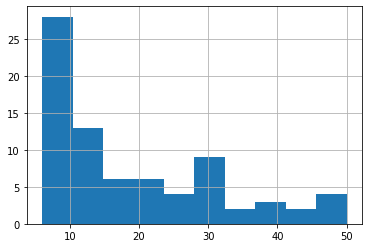

In [25]:
ax = y.hist()

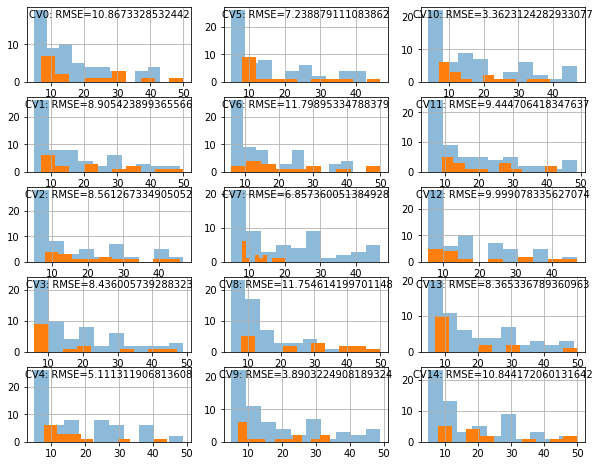

In [26]:
fig, ax = plt.subplots(5, 3, figsize=(10, 8))
_ = [ax[idx % 5, idx // 5].hist(cv["train"]["y"], alpha=0.5) for idx, cv in enumerate(cv_results)]
_ = [cv["test"]["y"].hist(alpha=1, ax=ax[idx % 5, idx // 5]) for idx, cv in enumerate(cv_results)]
_ = [ax[idx % 5, idx // 5].text(x=0.5, y=0.9, s=f"CV{idx}: RMSE={cv['test']['rmse']}",
                                horizontalalignment='center',
                                verticalalignment='center',
                                transform=ax[idx % 5, idx // 5].transAxes)
     for idx, cv in enumerate(cv_results)]

In [27]:
print(np.mean([np.count_nonzero(cv["beta_hat"]) / len(cv["beta_hat"]) for cv in cv_results]))
print(np.std([np.count_nonzero(cv["beta_hat"]) / len(cv["beta_hat"]) for cv in cv_results]))

0.8806519348065193
0.23959730198642507


# Feature Importance

Let's sort the features by their importance

In [28]:
columns_md_fa = columns.drop(['ad', 'cl', 'curvature', 'rd', 'torsion', 'volume'], level=0)
columns_md_fa = columns_md_fa.remove_unused_levels()

In [29]:
feature_dicts = afqi.multicol2dicts(columns_md_fa, tract_symmetry=False)

mean_beta = np.mean(np.array(
    [np.delete(res["beta_hat"], 4000) for res in hp_cv_res_medae_md_fa]
), axis=0)

var_beta = np.std(np.array(
    [np.delete(res["beta_hat"], 4000) for res in hp_cv_res_medae_md_fa]
), axis=0)

sorted_features = afqi.sort_features(feature_dicts, mean_beta)

# sorted_features[0:50]

It's nice to see the top few features in a sorted list, but let's plot the features to get a feel for their distributions

In [30]:
beta_hats = afqi.beta_hat_by_groups(mean_beta, columns=columns_md_fa, drop_zeros=True)
beta_hats_var = afqi.beta_hat_by_groups(var_beta, columns=columns_md_fa, drop_zeros=True)
# beta_hats_converged = afqi.beta_hat_by_groups(mean_beta_converged, columns=columns, drop_zeros=True)

First let's plot the coefficients themselves

In [31]:
unfolded_beta = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=mean_beta,
    columns=columns_md_fa
)

unfolded_beta_var = afqi.transform.unfold_beta_hat_by_metrics(
    beta_hat=var_beta,
    columns=columns_md_fa
)

In [32]:
afqi.plot.plot_unfolded_beta(
    unfolded_beta=unfolded_beta,
    output_html='../docs/img/bokeh_plots/regression_unfolded_beta.html',
    width=1500,
    height=800
)

In [33]:
afqi.plot.plot_unfolded_beta(
    unfolded_beta=unfolded_beta_var,
    output_html='../docs/img/bokeh_plots/regression_unfolded_beta_variance.html',
    width=1500,
    height=800
)

In [31]:
from dipy.viz import window, actor
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
from dipy.tracking.streamline import transform_streamlines
from dipy.viz import colormap

import json

In [32]:
with open("../data/raw/core_streamlines.json") as fp:
    cores = json.load(fp)

In [33]:
import deepdish as dd

In [34]:
# dd.io.save("age_regression_betas.h5", beta_hats)

/Users/arokem/.virtualenvs/afqinsight_test/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Callosum Forceps Major'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/arokem/.virtualenvs/afqinsight_test/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Callosum Forceps Minor'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/arokem/.virtualenvs/afqinsight_test/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Left Arcuate'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you

In [35]:
renderer = window.Renderer()

renderer.background((1, 1, 1))
metric = "fa"
colors = np.concatenate([beta_hats[bn][metric] for bn in beta_hats.keys()])
bundle_names = beta_hats.keys()
bundles = [np.array(cores[bn]["coreFiber"]) for bn in bundle_names]
cmap = actor.create_colormap(colors, name="coolwarm")

if encode_variance:
    alpha = np.concatenate([beta_hats_var[bn][metric] for bn in beta_hats.keys()])[:, np.newaxis]
    alpha = np.interp(alpha, (alpha.min(), alpha.max()), (1, 0))
    cmap = np.hstack([cmap, alpha])

stream_actor = actor.line(
    lines=bundles,
    colors=cmap,
    linewidth=20,
    spline_subdiv=5000,
    fake_tube=False,
)

ctable = colormap.colormap_lookup_table()
ctable.SetNumberOfTableValues(2000)
cmap_sorted = actor.create_colormap(np.sort(colors), name="coolwarm")
for idx, col in enumerate(cmap_sorted):
    ctable.SetTableValue(idx, col[0], col[1], col[2], 1.0)

ctable.SetTableRange(np.min(colors), np.max(colors))
cbar = actor.scalar_bar(ctable)
tprop = cbar.GetLabelTextProperty()
tprop.SetColor(0.0, 0.0, 0.0)
cbar.SetLabelTextProperty(tprop)

renderer.set_camera(
    position=(-4.28, 25.32, 430.00),
    focal_point=(3.23, -23.03, 18.32),
    view_up=(0.05, 1.00, -0.10)
)

renderer.add(stream_actor)
cbar.SetPosition((0.65, 0.185))
renderer.add(cbar)
vtkaxes = actor.axes(scale=(30, 30, 30))
vtkaxes.SetPosition((80, 30, 0))
renderer.add(vtkaxes)
window.show(renderer, size=(1800, 1800))
# window.record(renderer, out_path='regression_beta_nofaketube.png', size=(1800, 1800))

## Plot tract profiles for important features

In [36]:
tract_names = ["Left Cingulum Cingulate", "Callosum Forceps Minor"]
tract_stats = {}
for tid in tract_names:
    tract_stats[tid] = stat[stat["tractID"] == tid].drop("tractID", axis="columns")

50

In [72]:
import seaborn as sns

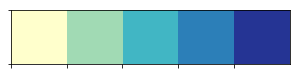

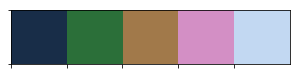

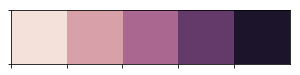

In [73]:
cat5 = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]
sns.palplot(sns.color_palette(cat5))
sns.palplot(sns.color_palette("cubehelix", 5))
sns.palplot(sns.cubehelix_palette(5, dark=0.1, light=0.9))

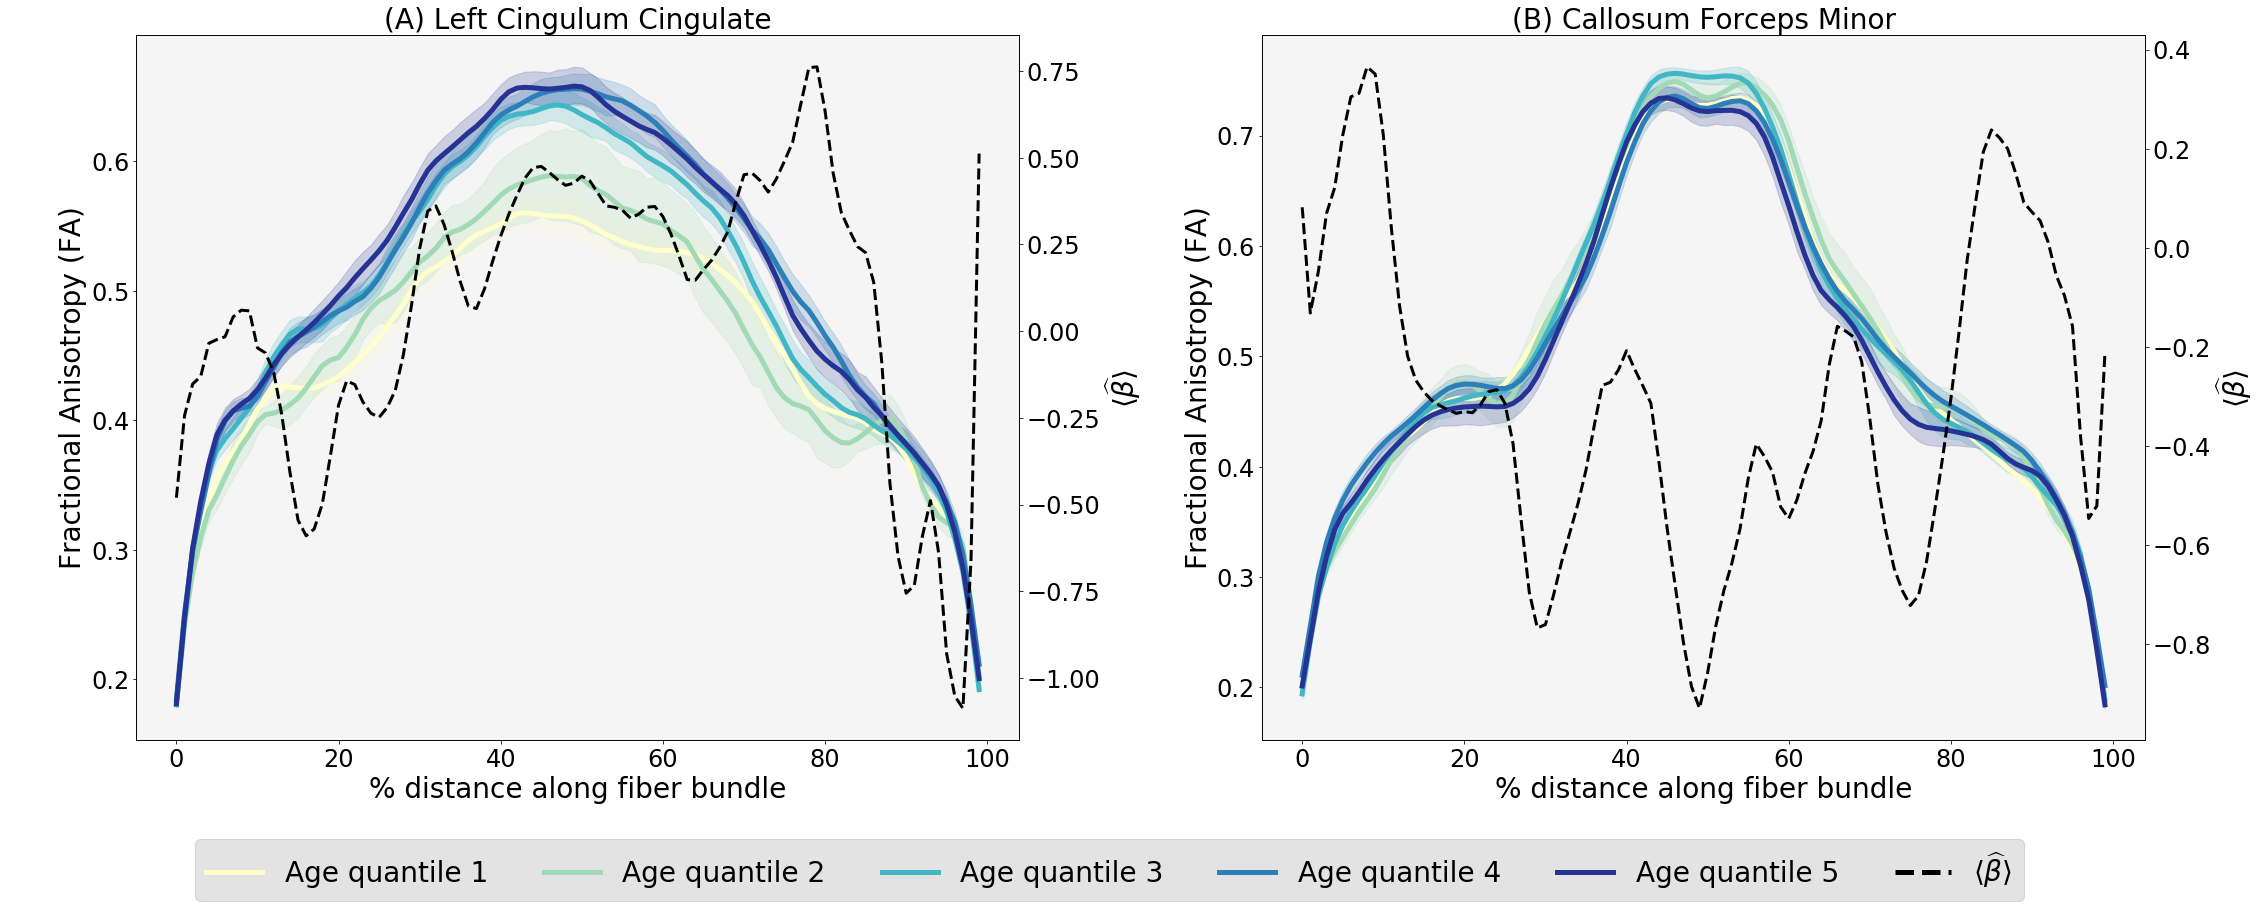

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 14))
ticksize = 24
labelsize = 28
titlesize = 28
bgcolor = "whitesmoke"

for ax, df_stat, title in zip(axes, tract_stats.values(), tract_stats.keys()):
    sns.lineplot(
        x="nodeID", y="fa", hue="Age Quintile", data=df_stat,
        ci=68.2, palette=cat5,
        ax=ax,
        linewidth=5.0
    )

    _ = ax.set_xlabel("% distance along fiber bundle", fontsize=labelsize)
    _ = ax.set_ylabel("Fractional Anisotropy (FA)", fontsize=labelsize)
    _ = ax.tick_params(axis='both', which='major', labelsize=ticksize)
    _ = ax.set_facecolor(bgcolor)
    _ = ax.get_legend().remove()
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    
    ax2 = ax.twinx()
    beta_line = ax2.plot(beta_hats[title]["fa"], linestyle="--", color="black", linewidth=3.0)
    _ = ax2.set_ylabel(r"$\langle \widehat{\beta} \rangle$", fontsize=labelsize)
    _ = ax2.tick_params(axis='both', which='major', labelsize=ticksize)

_ = axes[0].set_title("(A) " + tract_names[0], fontsize=titlesize)
_ = axes[1].set_title("(B) " + tract_names[1], fontsize=titlesize)

handles, labels = axes[1].get_legend_handles_labels()
handles = handles[1:] + beta_line
labels = ["Age quantile 1",
          "Age quantile 2",
          "Age quantile 3",
          "Age quantile 4",
          "Age quantile 5",
          r"$\langle \widehat{\beta} \rangle$"]

fig.subplots_adjust(bottom=0.18, wspace=0.275)

leg = plt.figlegend(
    handles, labels,
    fontsize=labelsize, facecolor="gainsboro",
    bbox_to_anchor=(0.428, 0.0),
    loc="lower center",
    ncol=6
)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

fig.savefig("regression_tract_profiles.pdf", bbox_inches="tight")